In [1]:
#Last part of the social dynamics project :D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import correlate2d
import itertools

import utils


palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)
cmap_no_empty = LinearSegmentedColormap.from_list('cmap', (palette[1], palette[0]))

def decorate(**options):
    plt.gca().set(**options)
    plt.tight_layout()


def decorate_seg():
    decorate(xlabel='Number of steps',
             ylabel='Average number of same-color neighbors',
             title='Schelling model')


class City:
    def __init__(self, n, r=1, square=False, probs=(0.1, 0.45, 0.45)):
        self.array = np.zeros((n, n))
        self.kernel = np.zeros((2*r+1, 2*r+1))
        self.make_grid(n, probs)
        self.make_kernel(r, square)

    @property
    def grid(self):
        return self.array

    def make_kernel(self, r, square=False):
        size = 2 * r + 1
        shape = (size, size)
        if square:  # Original kernel
            self.kernel = np.ones(shape, dtype=np.int8)
            self.kernel[r, r] = 0
        else: 
            # Variable radius kernel. I don't know how to do this with 2d list
            # comprehension stuff so I just for looped it. It also is only 
            # run once and kernel isn't very large.
            self.kernel = np.zeros(shape, dtype=np.int8)
            for i in range(0, 2*r+1):
                for j in range(0, 2*r+1):
                    # print(i, j)
                    manhattan_dist = abs(i-r) + abs(j-r)
                    self.kernel[i, j] = (manhattan_dist <= r) and (manhattan_dist != 0)

    def make_grid(self, n, probs):
        """Make an array with two types of agents.
        
        n: width and height of the array
        probs: probability of generating a 0, 1, or 2
        
        return: NumPy array
        """
        choices = np.array([0, 1, 2], dtype=np.int8)
        self.array = np.random.choice(choices, (n, n), p=probs)

    def draw(self, plot_show=True, grid_lines=False):
        """
        Draws the grid.
        """
        # Make a copy because some implementations
        # of step perform updates in place.
        a = self.grid.copy()
        n, m = a.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        options = dict(interpolation='none', alpha=0.8)
        options['extent'] = [0, m, 0, n]
        plt.imshow(a, cmap if len(utils.locs_where(self.grid == 0)) > 0 else cmap_no_empty, **options)
        if grid_lines:
            ax = plt.gca()
            ax.set_xticks(np.arange(0, self.array.shape[0], 1))
            ax.set_yticks(np.arange(0, self.array.shape[1], 1))
            ax.grid(color='k')
        if plot_show:
            plt.show()

    def compute_percent_same(self):
        """For each cell, the number of same-color neighbors as a
        percentage of the number of non-empty neighbors.
        
        return: new NumPy array
        """
        kernel = self.kernel
        non_empty = self.grid != 0
        red = self.grid == 1
        blue = self.grid == 2

        # count red neighbors, blue neighbors, and total
        options = dict(mode='same', boundary='wrap')
        num_not_empty = correlate2d(non_empty, kernel, **options)
        num_red = correlate2d(red, kernel, **options)
        num_blue = correlate2d(blue, kernel, **options)

        # Note: This is slightly different than Allen's original implementation
        # This uses the percent of neighbors that are the same - empty neighbors are essentially not counted
        # On the off chance of only empty neighbors, the cell is assumed to be completely happy
        total_neighbors = sum(self.kernel)
        np.seterr(divide='ignore', invalid='ignore')
        percent_same = np.where(num_not_empty == 0, 1,
                                np.where(blue, num_blue, np.where(red, num_red, num_not_empty)) / num_not_empty)
        return percent_same

    def avg_percent_same(self):
        """
        returns the average percent same
        """
        return self.compute_percent_same().mean()

    def move(self, source, dest):
        """Swap the agents at source and dest.

        source: location tuple
        dest: location tuple
        """
        self.array[dest], self.array[source] = self.array[source].copy(), self.array[dest].copy()  # Need these .copy for the Homo/Hetero model

    def find_unhappy(self, threshold=0.375):
        """
        Find the locations where cells are unhappy

        threshold: percent of same-color neighbors needed to be happy

        returns a list of tuples giving the indexes of each unhappy location
        """
        percent_same = self.compute_percent_same()
        return utils.locs_where(percent_same < threshold)

    def step(self, threshold=0.375):
        """Simulate one time step.

        threshold: percent of same-color neighbors needed to be happy

        returns the number of unhappy locations
        """
        unhappy_locs = self.find_unhappy(threshold)
        if len(unhappy_locs) > 0:
            empty_locs = utils.locs_where(self.grid == 0)
            source = utils.random_loc(unhappy_locs)
            dest = utils.random_loc(empty_locs)
            self.move(source, dest)
        return len(unhappy_locs)

    def loop(self, num_steps=1000, threshold=0.375):
        for _ in range(num_steps):
            self.step(threshold)

    def loop_until_done(self, threshold=0.375, max_steps=10000):
        for i in (range(max_steps) if max_steps > 0 else itertools.count()):
            num_unhappy = self.step(threshold)
            if num_unhappy == 0:
                return self.avg_percent_same(), i
        return self.avg_percent_same(), max_steps

    
print('fet')

fet


[[1 2 3]
 [4 5 6]
 [7 8 9]]


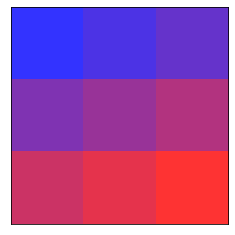

fet


In [2]:
# -*- coding: utf-8 -*-
"""Project 1.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1i4O1vY2kFWk7GIRSuuoJQUETyMi2BT2v

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1027.3357&rep=rep1&type=pdf
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy.signal import correlate2d
import numba as nb


def decorate(**options):
    plt.gca().set(**options)
    plt.tight_layout()


# make a custom color map
brg = cm.get_cmap('brg', 512)
br_array = brg(np.linspace(0, 0.5, 256))
cmap_no_empty = ListedColormap(br_array)
cmap = ListedColormap(np.concatenate((np.ones((256, 4)), br_array)))


def draw(grid):
    """Draws the grid.
    
    grid: NumPy array
    """
    # Make a copy because some implementations
    # of step perform updates in place.
    a = grid.copy()
    n, m = a.shape
    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    options = dict(interpolation='none', alpha=0.8)
    options['extent'] = [0, m, 0, n]
    return plt.imshow(a, cmap if (grid == -1).sum() > 0 else cmap_no_empty, **options)


# New Section
def make_city(n, p_empty=0.1):
    choices = np.array([0, 1], dtype=np.int8)
    probs = [p_empty, 1 - p_empty]
    empty_city = np.random.choice(choices, (n, n), p=probs)
    full_city = np.random.rand(n, n)
    return (empty_city - 1) + full_city * empty_city


def locs_where(condition):
    """Find cells where a boolean array is True.
    
    condition: NumPy array
    
    return: list of coordinate pairs
    """
    ii, jj = np.nonzero(condition)
    return list(zip(ii, jj))

def random_loc(locs):
    """Choose a random element from a list of tuples.
    
    locs: list of tuples
    
    return: tuple
    """
    index = np.random.choice(len(locs))
    return locs[index]

city = np.arange(1,10).reshape(3,3)
print(city)
draw(city)
plt.show()

kernel = np.array([[0.125, 0.125, 0.125],
                   [0.125, -1.00, 0.125],
                   [0.125, 0.125, 0.125]])
corr = correlate2d(city, kernel, boundary='wrap', mode='same')
corr

@nb.njit
def get_avg_abs_diff(arr):
    n,m = arr.shape
    out = np.empty((n,m))
    for i in range(n):
        for j in range(m):
            a = max(0,i-1)
            b = i+2
            c = max(0,j-1)
            d = j+2
            neighbors = arr[a:b,c:d]
            empty = neighbors == -1
            out[i,j] = np.sum(np.abs(neighbors-arr[i,j]) * (1 - empty))/(neighbors.shape[0]*neighbors.shape[1] - 1 - np.sum(empty))
    return out

# Commented out IPython magic to ensure Python compatibility.
# %timeit correlate2d(make_city(10000), kernel)

# Commented out IPython magic to ensure Python compatibility.
# %timeit get_avg_abs_diff(make_city(10000))

city[0, 0] = -1
city[2, 2] = -1
get_avg_abs_diff(city)

print('fet')

        preference  segregation
radius                         
1             0.20     0.634900
2             0.20     0.578031
3             0.20     0.553451
4             0.20     0.556444
5             0.20     0.550639
6             0.20     0.550832
7             0.20     0.547524
1             0.25     0.641492
2             0.25     0.592513
3             0.25     0.554213
4             0.25     0.551639
5             0.25     0.550665
6             0.25     0.550557
7             0.25     0.549527
1             0.30     0.790200
2             0.30     0.699923
3             0.30     0.606485
4             0.30     0.568127
5             0.30     0.552758
6             0.30     0.551571
7             0.30     0.549769
1             0.35     0.840242
2             0.35     0.808586
3             0.35     0.859146
4             0.35     0.840217
5             0.35     0.847278
6             0.35     0.579098
7             0.35     0.562172
1             0.40     0.837617
2       

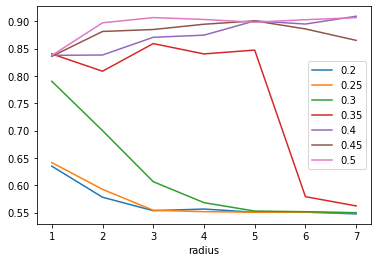

fet


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os



data = pd.read_csv("data.csv") # load csv
data = data.groupby(by = ["preference", "radius"]).mean() # take mean by preference and radius
data = data.reset_index() # can't figure out how to unset only 1 index
data = data.set_index("radius") # set index to radius
print(data)

# group data by preference, take segregation column, and plot
data.groupby("preference")["segregation"].plot(x = "radius", y = "segregation", legend = True)
plt.show()

print('fet')

In [ ]:
import csv
import os
import multiprocessing as mp
import numpy as np


# city = City(50, r=3)
# city.draw()
# segs = [city.step() for i in range(10000)]
# plt.plot(segs)
# decorate_seg()
# plt.show()

# plt.figure()
# im = city.draw()

##########################################
# city = City(n=50, r = 7, square = False)

# # draw the initial grid
# plt.figure(figsize=(9,3))
# plt.subplot(1,3,1)
# city.draw(plot_show = False)

# # first update
# plt.subplot(1,3,2)
# for i in range(1000):
#     city.step()
# city.draw(plot_show = False)

# # second update
# plt.subplot(1,3,3)
# for i in range(1000, 2000):
#     city.step()
# city.draw(plot_show = False)

# plt.tight_layout()
# plt.show()

#################################

# city = City(50, r=7, square=False)
# print(city.kernel)
# plt.figure(1)
# city.draw()
# city.loop()
# plt.figure(2)
# city.draw()

##################################
# Test different radii over time

# nSteps = 10000
# radii = 7
# city_size = 50
# segs = np.zeros((nSteps, radii))
# for r in range(1, radii+1):
#     print("                                ", end = "\r")
#     city = City(city_size, r = r)
#     for s in range(nSteps):
#         segs[s, r-1] = city.step()
#         # print("Radius: " + str(r) + ", Steps: " + str(s), end = "\r")

# plt.plot(segs)
# plt.legend(range(1, radii+1))
# plt.show()

###################################

# nSteps = 2000
# radii = range(1, 5)
# # preferences = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# preferences = [0.2, 0.3, 0.4, 0.5]
# city_size = 20
# # p_out = []
# # r_out = []
# # s_out = []
# output = []
# output_rows = []

# for p in preferences:
#     print("                                                                       ", end = "\r")
#     this_x_out = []
#     this_y_out = []
#     for r in radii:
#         city = City(city_size, r = r)
#         for s in range(nSteps):
#             city.step(threshold = p)
#         print("Preference: " + str(p) + ", Radius: " + str(r), end = "\r")
#         # this_p_out.append([r, np.mean(city.compute_percent_same())])
#         s = np.mean(city.compute_percent_same())
#         this_x_out.append(r)
#         this_y_out.append(s)
#         output_rows.append([p, r, s])
#     output.append((p, [this_x_out, this_y_out]))

# print(output)
# for o in output:
#     this_p = o[1]
#     plt.plot(this_p[0], this_p[1])
# plt.legend(preferences)
# plt.show()

###############################
nSteps = 10000
radii = range(1, 8)
preferences = [0.2, 0.25, 0.3, 0.325, 0.35, 0.4, 0.45, 0.5]
hetero_ps = np.arange(0, 1, 0.1)
# preferences = [0.2, 0.3, 0.4, 0.5]
city_size = 50  # paper uses 50
output_rows = []


def calculate_s(r, pref, p_hetero, i):
    # For a given radius and preference, run the simulation
    # i is for troubleshooting, doesn't do anything
    city = HomoHeteroCity(city_size, r=r, hetero_prob=p_hetero)
    s, t = city.loop_until_done(threshold = pref, max_steps=nSteps)
    # s = np.mean(city.compute_percent_same())
    print(f'Preference: {pref}, Radius: {r}, P(Hetero): {p_hetero}, I: {i}')
    return [pref, r, p_hetero, s, t, city_size]


if __name__ == "__main__":
    params = []
    for i in range(5):  # Make an array of tuples of all combinations of input arguments
        for r in radii:
            for pr in preferences:
                for ph in hetero_ps:
                    params.append((r, pr, ph, i))
    
    with mp.Pool() as pool: # have the pool map each tuple onto calculate_s arguments
        # Starmap is just unpacking the tuple into multiple arguments
        # This will complete the operation with an optimal number of pool workers,
        # making use of all CPU cores.
        output_rows = pool.starmap(calculate_s, params)
                
    # Sort and add header to the list
    output_rows.sort()
    headers = ["preference", "radius", "percent_hetero", "segregation", "num_steps", "city_size"]
    output_rows.insert(0, headers)
    print(output_rows)
    
    # Write the output list to CSV
    wd = os.path.dirname(__file__)
    path = os.path.join(wd, "data", "ext_data.csv")
    with open(path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(output_rows)
        
print('fet')

In [4]:
import numpy as np
from schelling_base import City
import utils


class HomoHeteroCity(City):
    def __init__(self, n, r=1, square=False, color_probs=(0.1, 0.45, 0.45), hetero_prob=0.5):
        super().__init__(n, r, square, color_probs)
        self.make_grid(n, color_probs, hetero_prob)

    @property
    def grid(self):
        return self.array[:, :, 0]

    def make_grid(self, n, color_probs=(0.1, 0.45, 0.45), hetero_prob=0.5):
        super().make_grid(n, color_probs)
        grid = self.array.copy()
        hetero = np.random.random((n, n)) < hetero_prob
        self.array = np.zeros((n, n, 2))
        self.array[:, :, 0] = grid
        self.array[:, :, 1] = hetero

    @property
    def hetero(self):
        return self.array[:, :, 1]

    def find_unhappy(self, threshold=0.375):
        percent_same = self.compute_percent_same()
        unhappy_homo = (self.hetero == 0) & (percent_same < threshold)
        unhappy_hetero = (self.hetero == 1) & ((percent_same < threshold / 2) | (percent_same > 1 - threshold / 2))
        return utils.locs_where(unhappy_hetero) + utils.locs_where(unhappy_homo)

    
    
print('fet')

fet


In [ ]:
from schelling_base import City
import matplotlib.pyplot as plt

# For the draw function in schelling_base:
# plt.imshow(a, cmap = "gray", **options)

ax = plt.subplot(2,4,1)
city = City(n=15,r=1,square=True)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("Moore Kernel")

ax = plt.subplot(2,4,2)
city = City(n=15,r=1)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=1")

ax = plt.subplot(2,4,3)
city = City(n=15,r=2)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=2")

ax = plt.subplot(2,4,4)
city = City(n=15,r=3)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=3")

ax = plt.subplot(2,4,5)
city = City(n=15,r=4)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=4")

ax = plt.subplot(2,4,6)
city = City(n=15,r=5)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=5")

ax = plt.subplot(2,4,7)
city = City(n=15,r=6)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=6")

ax = plt.subplot(2,4,8)
city = City(n=15,r=7)
city.array = 1- city.kernel
city.draw(plot_show = False)
ax.set_title("R=7")

plt.show()

In [ ]:
2+2

In [ ]:
from schelling_base import City
from schelling_expansion import HomoHeteroCity
import csv
import os
import multiprocessing as mp
import numpy as np


city = City(50, r=3)
city.draw()
segs = [city.step() for i in range(10000)]
plt.plot(segs)
decorate_seg()
plt.show()

plt.figure()
im = city.draw()

##########################################
city = City(n=50, r = 7, square = False)

# # draw the initial grid
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
city.draw(plot_show = False)

# # first update
plt.subplot(1,3,2)
for i in range(1000):
    city.step()
# 
city.draw(plot_show = False)

# # 
second update
plt.subplot(1,3,3)
for i in range(1000, 2000):
    city.step()

city.draw(plot_show = False)

plt.tight_layout()
plt.show()

#################################
city = City(50, r=7, square=False)
print(city.kernel)
plt.figure(1)
city.draw()
city.loop()
plt.figure(2)
city.draw()

##################################
# Test different radii over time

nSteps = 10000
radii = 7
city_size = 50
segs = np.zeros((nSteps, radii))
for r in range(1, radii+1):
    print("                                ", end = "\r")
    city = City(city_size, r = r)
    for s in range(nSteps):
        segs[s, r-1] = city.step()
        print("Radius: " + str(r) + ", Steps: " + str(s), end = "\r")

plt.plot(segs)
plt.legend(range(1, radii+1))
plt.show()

###################################

nSteps = 2000
radii = range(1, 5)
preferences = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
preferences = [0.2, 0.3, 0.4, 0.5]
city_size = 20
p_out = []
r_out = []
s_out = []
output = []
output_rows = []

for p in preferences:
    print("                                                                       ", end = "\r")
    this_x_out = []
    this_y_out = []
    for r in radii:
        city = City(city_size, r = r)
        for s in range(nSteps):
            city.step(threshold = p)
            print("Preference: " + str(p) + ", Radius: " + str(r), end = "\r")
            this_p_out.append([r, np.mean(city.compute_percent_same())])
            s = np.mean(city.compute_percent_same())
            this_x_out.append(r)
            this_y_out.append(s)
            output_rows.append([p, r, s])
    output.append((p, [this_x_out, this_y_out]))

print(output)
for o in output:
    this_p = o[1]
    plt.plot(this_p[0], this_p[1])
plt.legend(preferences)
plt.show()

###############################
nSteps = 10000
radii = range(1, 8)
preferences = [0.2, 0.25, 0.3, 0.325, 0.35, 0.4, 0.45, 0.5]
hetero_ps = np.arange(0, 1, 0.1)
# preferences = [0.2, 0.3, 0.4, 0.5]
city_size = 50  # paper uses 50
output_rows = []


def calculate_s(r, pref, p_hetero, i):
    # For a given radius and preference, run the simulation
    # i is for troubleshooting, doesn't do anything
    city = HomoHeteroCity(city_size, r=r, hetero_prob=p_hetero)
    s, t = city.loop_until_done(threshold = pref, max_steps=nSteps)
    # s = np.mean(city.compute_percent_same())
    print(f'Preference: {pref}, Radius: {r}, P(Hetero): {p_hetero}, I: {i}')
    return [pref, r, p_hetero, s, t, city_size]


if __name__ == "__main__":
    params = []
    for i in range(5):  # Make an array of tuples of all combinations of input arguments
        for r in radii:
            for pr in preferences:
                for ph in hetero_ps:
                    params.append((r, pr, ph, i))
    
    with mp.Pool() as pool: # have the pool map each tuple onto calculate_s arguments
        # Starmap is just unpacking the tuple into multiple arguments
        # This will complete the operation with an optimal number of pool workers,
        # making use of all CPU cores.
        output_rows = pool.starmap(calculate_s, params)
                
    # Sort and add header to the list
    output_rows.sort()
    headers = ["preference", "radius", "percent_hetero", "segregation", "num_steps", "city_size"]
    output_rows.insert(0, headers)
    print(output_rows)
    
    # Write the output list to CSV
    wd = os.path.dirname(__file__)
    path = os.path.join(wd, "data", "ext_data.csv")
    with open(path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(output_rows)
        
        

In [2]:
2+2

4

In [1]:
print('hola')

hola


In [ ]:
%run main2.py

In [ ]:
phs = [0, 0.4, 0.8]
steps = (0, 500, 1000)
ts = [0.2, 0.3, 0.4]

for phi, ph in enumerate(phs):
    for ti, t in enumerate(ts):
        city = HomoHeteroCity(50, r=4, hetero_prob=ph)
        city.loop_until_done(threshold=t)
        index = phi * len(phs) + ti + 1
        plt.subplot(len(phs), len(ts), index)
        city.draw(plot_show=False)
        if index == phi * len(phs) + 1:
            plt.ylabel(f'% Hetero = {ph}')
        if index > len(phs) * (len(phs) - 1):
            plt.xlabel(f'Threshold = {t}')
        if index == len(ts) // 2 + 1:
            plt.title(f'Equilibrium States for Varying Cities')
        print(f'Finished {t}, {ph}')
plt.show()

Finished 0.2, 0
Finished 0.3, 0
Finished 0.4, 0
Finished 0.2, 0.4


alla vamos


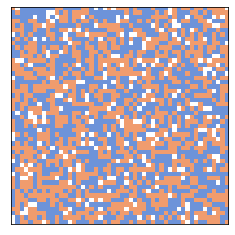

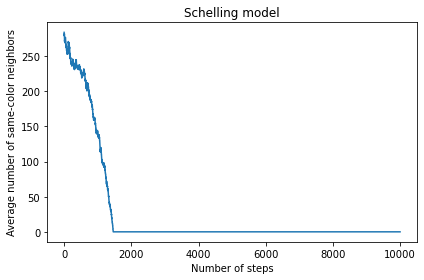

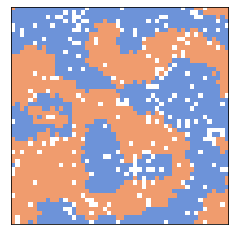

In [5]:
city = City(50, r=3)
print('alla vamos')
city.draw()
segs = [city.step() for i in range(10000)]
plt.plot(segs)
decorate_seg()
plt.show()

plt.figure()
im = city.draw()

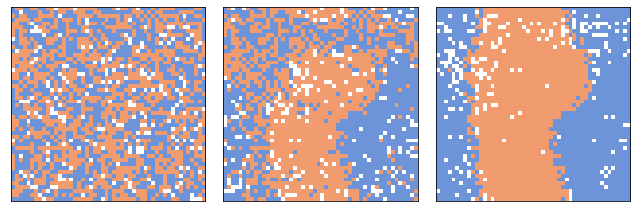

[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


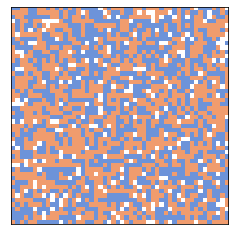

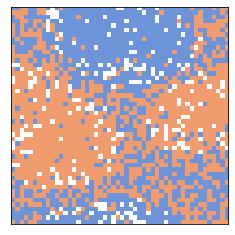

In [6]:
city = City(n=50, r = 7, square = False)

# draw the initial grid
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
city.draw(plot_show = False)

# # first update
plt.subplot(1,3,2)
for i in range(1000):
    city.step()

city.draw(plot_show = False)

# # second update
plt.subplot(1,3,3)
for i in range(1000, 2000):
    city.step()

city.draw(plot_show = False)

plt.tight_layout()
plt.show()

#################################

city = City(50, r=7, square=False)
print(city.kernel)
plt.figure(1)
city.draw()
city.loop()
plt.figure(2)
city.draw()

##################################
# Test different radii over time

# nSteps = 10000
# radii = 7
# city_size = 50
# segs = np.zeros((nSteps, radii))
# for r in range(1, radii+1):
#     print("                                ", end = "\r")
#     city = City(city_size, r = r)
#     for s in range(nSteps):
#         segs[s, r-1] = city.step()
#         # print("Radius: " + str(r) + ", Steps: " + str(s), end = "\r")

# plt.plot(segs)
# plt.legend(range(1, radii+1))
# plt.show()

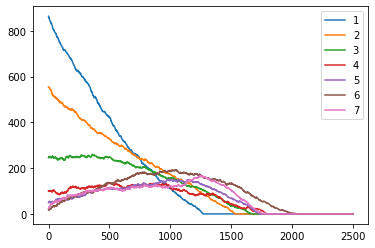

In [9]:
#Test different radii over time

nSteps = 2500
radii = 7
city_size = 50
segs = np.zeros((nSteps, radii))
for r in range(1, radii+1):
    print("                                ", end = "\r")
    city = City(city_size, r = r)
    for s in range(nSteps):
        segs[s, r-1] = city.step()
        print("Radius: " + str(r) + ", Steps: " + str(s), end = "\r")

plt.plot(segs)
plt.legend(range(1, radii+1))
plt.show()

In [11]:


nSteps = 2000
radii = 4
city_size = 50
segs = np.zeros((nSteps, radii))
for r in range(1, radii+1):
    print("                                ", end = "\r")
    city = City(city_size, r = r)
    for s in range(nSteps):
        segs[s, r-1] = city.step()
    print("Radius: " + str(r) + ", Steps: " + str(s), end = "\r")

plt.plot(segs)
plt.legend(range(1, radii+1))
plt.show()

IndentationError: expected an indented block (Temp/ipykernel_356/522057975.py, line 9)

In [19]:

nSteps = 2000
radii = np.arange(1,8)
preferences = [0.3, 0.5]
p_out = []
r_out = []
s_out = []
output = []
output_rows = []

for p in preferences:
    print("                                                                       ", end = "\r")
    this_x_out = []
    this_y_out = []
    for r in radii:
        city = City(city_size, r = r)
        for s in range(nSteps):
            city.step(threshold = p)
        print("Preference: " + str(p) + ", Radius: " + str(r), end = "\r")
        #this_p_out.append([r, np.mean(city.compute_percent_same())])
        s = np.mean(city.compute_percent_same())
        this_x_out.append(r)
        this_y_out.append(s)
        output_rows.append([p, r, s])
    output.append((p, [this_x_out, this_y_out]))

print(output)
for o in output:
    this_p = o[1]
    plt.plot(this_p[0], this_p[1], label=r'$p=%s$'%preferences[o])

plt.legend(preferences)
plt.show()


[(0.3, [[1, 2, 3, 4, 5, 6, 7], [0.7864, 0.684856378066378, 0.5970404704283766, 0.5622152655725011, 0.55311316378274, 0.5570828139743995, 0.544209334087531]]), (0.5, [[1, 2, 3, 4, 5, 6, 7], [0.8404333333333333, 0.8624790187590188, 0.823526500090224, 0.8168407137185216, 0.7955862666330848, 0.7539371759270249, 0.7710043615315044]])]


TypeError: list indices must be integers or slices, not tuple

In [ ]:

nSteps = 2000
radii = np.arange(1,8)
preferences = [0.3, 0.5]
p_out = []
r_out = []
s_out = []
output = []
output_rows = []

for p in preferences:
    print("                                                                       ", end = "\r")
    this_x_out = []
    this_y_out = []
    for r in radii:
        city = City(city_size, r = r)
        for s in range(nSteps):
            city.step(threshold = p)
        print("Preference: " + str(p) + ", Radius: " + str(r), end = "\r")
        #this_p_out.append([r, np.mean(city.compute_percent_same())])
        s = np.mean(city.compute_percent_same())
        this_x_out.append(r)
        this_y_out.append(s)
        output_rows.append([p, r, s])
    output.append((p, [this_x_out, this_y_out]))

print(output)
for o in output:
    this_p = o[1]
    plt.plot(this_p[0], this_p[1], label=r'$p=%s$'%preferences[o])

plt.legend(preferences)
plt.show()


In [27]:

nSteps = 2000
radii = np.arange(1,8)
preferences = [0.2, 0.25,0.3,0.35,0.4,0.45,0.5]
p_out = []
r_out = []
s_out = []
output = []
output_rows = []

for p in preferences:
    print("                                                                       ", end = "\r")
    this_x_out = []
    this_y_out = []
    for r in radii:
        city = City(city_size, r = r)
        for s in range(nSteps):
            city.step(threshold = p)
        print("Preference: " + str(p) + ", Radius: " + str(r), end = "\r")
        #this_p_out.append([r, np.mean(city.compute_percent_same())])
        s = np.mean(city.compute_percent_same())
        this_x_out.append(r)
        this_y_out.append(s)
        output_rows.append([p, r, s])
    output.append((p, [this_x_out, this_y_out]))

print(output)
for o in output:
    this_p = o[1]
    plt.plot(this_p[0], this_p[1], label=r'$p=%s$'%preferences[o])

plt.legend(preferences)
plt.show()


[(0.2, [[1, 2, 3, 4, 5, 6, 7], [0.6501, 0.5767095526695526, 0.5464541238054059, 0.5429450880471511, 0.5557145794195176, 0.5456995073191939, 0.5533141106798465]]), (0.25, [[1, 2, 3, 4, 5, 6, 7], [0.6366666666666666, 0.5890648629148629, 0.5527886099082862, 0.5540375824281029, 0.5497441356753895, 0.5502527529399457, 0.5512910280267177]]), (0.3, [[1, 2, 3, 4, 5, 6, 7], [0.7842666666666667, 0.6833725396825397, 0.6187480773097619, 0.5650650595270355, 0.5556185149383033, 0.5527912786133271, 0.546060732751311]]), (0.35, [[1, 2, 3, 4, 5, 6, 7], [0.8347666666666668, 0.8111501587301587, 0.8276358445326678, 0.8320233003107788, 0.5780264628772064, 0.562320894897703, 0.553376132264709]]), (0.4, [[1, 2, 3, 4, 5, 6, 7], [0.8352333333333334, 0.8312805483405484, 0.8411956805192087, 0.8396490498725283, 0.8572232104287961, 0.8825541986695902, 0.8632333056530576]]), (0.45, [[1, 2, 3, 4, 5, 6, 7], [0.8324, 0.8712740692640695, 0.862129482589097, 0.8647135135116994, 0.8857147061296633, 0.8391116282333547, 0.8

TypeError: list indices must be integers or slices, not tuple

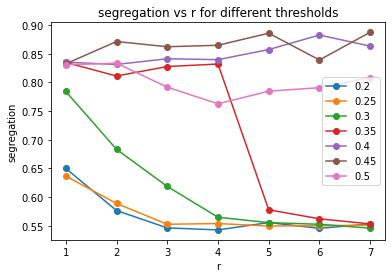

In [30]:
for o in output:
    this_p = o[1]
    plt.plot(this_p[0], this_p[1], '-o')
    plt.xlabel('r')
    plt.ylabel('segregation')

plt.legend(preferences)
plt.title('segregation vs r for different thresholds')
plt.show()

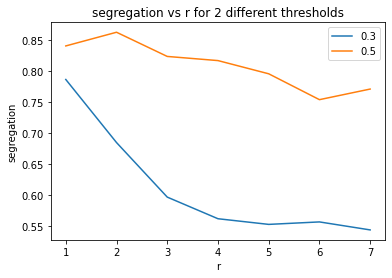

In [26]:
for o in output:
    this_p = o[1]
    plt.plot(this_p[0], this_p[1])
    plt.xlabel('r')
    plt.ylabel('segregation')

plt.legend(preferences)
plt.title('segregation vs r for 2 different thresholds')
plt.show()

In [23]:
np.index(o[1]

AttributeError: module 'numpy' has no attribute 'index'